# Import Data

First, we are going to import a small subset of the total data for exploratory data analysis. We are only interested in the tweets written in English.

In [1]:
# Import Packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import nltk
import random
import gensim
from pprint import pprint
from glob import glob
from nltk import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# Import all data
filenames = glob('Data/IRA*.csv')

df = pd.concat([pd.read_csv(f) for f in filenames])

In [3]:
# Select tweets in English
df = df[df['language'] == "English"]

# Convert date
df['publish_datetime'] = pd.to_datetime(df['publish_date'])
# Create generalized day for plotting
df['publish_date'] = df['publish_datetime'].dt.floor('d')

# Get rid of retweets here for consistency?

In [27]:
# Get rid of URLS for safety purposes
def drop_urls(tweet_content):
    """ Drops urls from tweets. Some tweets link to links I don't want to link to...
    """
    drop_url = re.sub(r"http\S+", "", tweet_content, flags=re.MULTILINE)
    return drop_url

df['content'] = df['content'].apply(drop_urls)

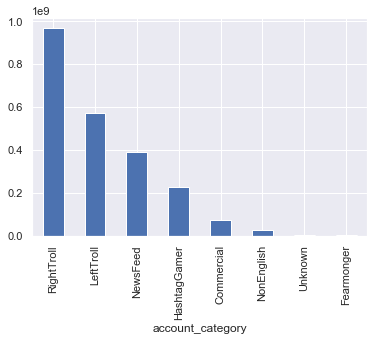

In [5]:
df_cat_updates = df.groupby('account_category')['updates'].sum().sort_values(ascending=False)

cat_plot = df_cat_updates.plot.bar()

In [6]:
accounts_max = df.groupby(['account_category', 'author']).max()

In [7]:
accounts_max.describe()

,alt_external_id,external_author_id,followers,following,new_june_2018,retweet,tweet_id,updates
count,4.260000e+02,4.260000e+02,426.000000,426.000000,426.000000,426.000000,4.260000e+02,426.000000
mean,2.811476e+17,2.811521e+17,1203.969484,1309.427230,0.248826,0.793427,7.757122e+17,2379.053991
std,4.076460e+17,4.076521e+17,4005.576270,2625.787747,0.432841,0.405322,1.080707e+17,5031.007545
min,3.497640e+07,3.497640e+07,0.000000,0.000000,0.000000,0.000000,4.574222e+17,2.000000
25%,1.868575e+09,1.868575e+09,56.250000,73.000000,0.000000,1.000000,6.729244e+17,295.000000
50%,2.615544e+09,2.615544e+09,136.500000,303.500000,0.000000,1.000000,7.582620e+17,597.500000
75%,8.443861e+17,8.441515e+17,676.250000,1326.000000,0.000000,1.000000,8.898363e+17,2667.750000
max,9.123939e+17,9.123940e+17,40788.000000,30194.000000,1.000000,1.000000,9.766389e+17,69979.000000


## Tweets by Category

In [8]:
# Define count_entries()
def count_entries(df, *args):
    """Return a dictionary with counts of
    occurrences as value for each key."""
    
    #Initialize an empty dictionary: cols_count
    cols_count = {}
    
    # Iterate over column names in args
    for col_name in args:
    
        # Extract column from DataFrame: col
        col = df[col_name]
    
        # Iterate over the column in DataFrame
        for entry in col:
    
            # If entry is in cols_count, add 1
            if entry in cols_count.keys():
                cols_count[entry] += 1
    
            # Else add the entry to cols_count, set the value to 1
            else:
                cols_count[entry] = 1

    # Return the cols_count dictionary
    return cols_count

# Call count_entries(): result
cat_count = count_entries(df, 'account_category')

cat_count

{'RightTroll': 160523,
 'Unknown': 1096,
 'LeftTroll': 120008,
 'NonEnglish': 4608,
 'HashtagGamer': 54267,
 'NewsFeed': 32800,
 'Fearmonger': 990,
 'Commercial': 12416}

# Basic Visualizations

These tweets occur over SUCH AND SUCH TIME. We will visualize as follows:

In [9]:
def grouped_daily_sum(tweets):
    
    #grouped_df = df.groupby(['account_category']).mean()
    grouped_daily = df.groupby(['publish_date','account_category']).size().reset_index(name='counts')
    return grouped_daily

daily_tweets = grouped_daily_sum(df)
daily_tweets.head()

,publish_date,account_category,counts
0,2012-10-30,LeftTroll,1
1,2012-11-21,LeftTroll,1
2,2012-11-28,LeftTroll,3
3,2013-02-01,LeftTroll,1
4,2013-04-27,LeftTroll,1


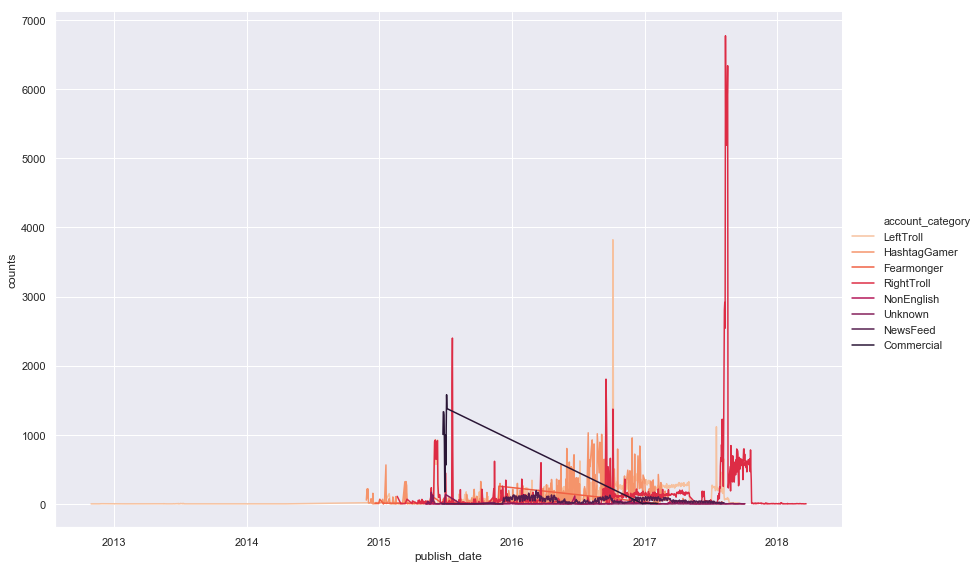

In [10]:
# Define a palette
palette = dict(zip(daily_tweets['account_category'].unique(),
                   sns.color_palette("rocket_r", 8)))

# Plot the lines on two facets
sns.relplot(data=daily_tweets,
            x='publish_date', y='counts',
            hue='account_category',
            palette=palette,
            height=8, aspect=12/8,
            kind="line", legend="full")

# Network Analysis

We are interested in the structure of the social network within which these accounts reside. 

From this dataset, we are only able to create a **mentions network**, since we do not have data regarding who has retweeted these tweets. In particular, we are intereset in which IRA accounts mention other IRA accounts, and how often. 

First, we need to create a function which uses regular expressions to extract the Twitter handles mentioned in each tweet. 


Then, we will create a function to construct a graph of mentions. This will be a directed graph, where each node represent an IRA account and each edge represents a direct mention.

In [11]:
def extract_usernames(tweet_content):
    """Function to extract usernames from tweets, accounting for email addresses
    """
    drop_emails = re.sub("[\w]+@[\w]+\.[c][o][m]", "", tweet_content)
    mentioned_users = re.findall("@([a-zA-Z0-9]{1,15})", drop_emails)
    return mentioned_users

# Create test data
test_tweets = df[['external_author_id','author',str('content'), 'retweet', 'account_category']]#.sample(50000, random_state=345)

# Filter out retweets
test_tweets = test_tweets[(test_tweets['retweet'] != 1) & (~test_tweets['content'].str.contains("RT"))]

# Apply username extraction function
test_tweets['mentions'] = test_tweets['content'].apply(extract_usernames)
test_tweets.head()

,external_author_id,author,content,retweet,account_category,mentions
18,2497991305,AUSTINLOVESBEER,#GayPride #PrayForGay Someone tell LGBT that t...,0,RightTroll,[]
19,2497991305,AUSTINLOVESBEER,Religion today is so easily rejected but it ha...,0,RightTroll,[]
20,2497991305,AUSTINLOVESBEER,#PrayForGay Don't think the law will actually ...,0,RightTroll,[]
21,2497991305,AUSTINLOVESBEER,#TolerantLeft Who can tell me whats wrong Mike...,0,RightTroll,[]
22,2497991305,AUSTINLOVESBEER,I'm angry but I still love you.,0,RightTroll,[]


In order to create a graph from this data, we need to unnest the mentions such that each mention represents a pairing between one 'author' and one 'mention'. Each account will represent a node, and each mention will represent an edge between them.

In [12]:
# Unnest multiple username mentions in tweet
expanded_mentions = pd.DataFrame({'author':test_tweets['author'].repeat(test_tweets['mentions'].str.len()),
                           'mentions':np.concatenate(test_tweets['mentions'].values),
                           'account_category':test_tweets['account_category'].repeat(test_tweets['mentions'].str.len())})
expanded_mentions['mentions'] = expanded_mentions['mentions'].str.upper()
expanded_mentions.head()

,author,mentions,account_category
80,AUSTINLOVESBEER,LNEVER,RightTroll
96,AUSTINLOVESBEER,JENN,RightTroll
97,AUSTINLOVESBEER,CLEVER,RightTroll
100,AUSTINLOVESBEER,BESTUSATODAY,RightTroll
103,AU_NORTON,JENN,Unknown


In this case, we are only interested in mentions of other IRA accounts. Note that sometimes IRA accounts mention themselves in a tweet. INCLUDE EXAMPLES OF THIS?

In [13]:
# Select only mentions of IRA accounts.
IRA_authors = df['author'].unique()

expanded_IRA_mentions = expanded_mentions[(expanded_mentions['mentions'].isin(IRA_authors))]
expanded_IRA_mentions

,author,mentions,account_category
53242,BERGERJAMIE75,BAYOFTAMARA,RightTroll
77751,BGARNER2107,ABIGAILSSILK,HashtagGamer
77824,BGARNER2107,ABIGAILSSILK,HashtagGamer
77831,BGARNER2107,ABIGAILSSILK,HashtagGamer
77849,BGARNER2107,ABIGAILSSILK,HashtagGamer
77890,BGARNER2107,ABIGAILSSILK,HashtagGamer
77897,BGARNER2107,ABIGAILSSILK,HashtagGamer
77988,BGARNER2107,ABIGAILSSILK,HashtagGamer
78029,BGARNER2107,ABIGAILSSILK,HashtagGamer
78052,BGARNER2107,ABIGAILSSILK,HashtagGamer


This network of mentions can be visualized using NetworkX. This is a directed graph, where the direction of the arrow represents a mention.

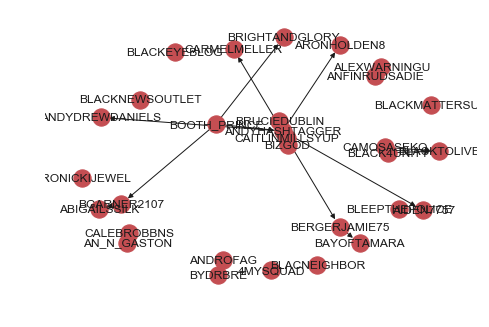

In [14]:
G=nx.from_pandas_edgelist(expanded_IRA_mentions,source='author',target='mentions',
                         edge_attr=True, create_using=nx.MultiDiGraph)
nx.draw(G, with_labels=True)

I am interested in betweenness centrality, which measures which users act as "bridges" between the network. For a more in-depth coverage of network measures, see https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/.

In [15]:
bet_cent = nx.betweenness_centrality(G, normalized = True)
bet_cent

{'BERGERJAMIE75': 0.0024630541871921183,
 'BAYOFTAMARA': 0.0,
 'BGARNER2107': 0.0012315270935960591,
 'ABIGAILSSILK': 0.0,
 'BIZGOD': 0.0,
 'CAITLINMILLSYUP': 0.003694581280788177,
 'BLACK4UNITY': 0.0,
 'BLACKTOLIVE': 0.0,
 'BLACKEYEBLOG': 0.0,
 'BLACKMATTERSUS': 0.0,
 'BLACKNEWSOUTLET': 0.0,
 'BLACNEIGHBOR': 0.0,
 'BLEEPTHEPOLICE': 0.0,
 'BOOTH_PRINCE': 0.0,
 'BRIGHTANDGLORY': 0.0,
 'ANDYHASHTAGGER': 0.007389162561576354,
 'BRONICKIJEWEL': 0.0,
 'BRUCIEDUBLIN': 0.0,
 'CARMELMELLER': 0.0,
 'CAMOSASEKO': 0.0,
 '4MYSQUAD': 0.0,
 'ANDROFAG': 0.0,
 'BYDRBRE': 0.0,
 'AIDEN7757': 0.0,
 'ARONHOLDEN8': 0.0,
 'ANDYDREWDANIELS': 0.0,
 'ANFINRUDSADIE': 0.0,
 'ALEXWARNINGU': 0.0,
 'AN_N_GASTON': 0.0,
 'CALEBROBBNS': 0.0}

(-1.1920216339006244,
 1.0207990996208571,
 -1.0844421167626306,
 1.1261704322674482)

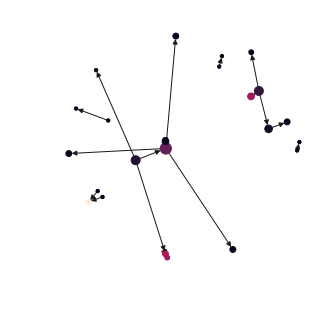

In [16]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

#code adapted from https://www.datacamp.com/community/tutorials/social-network-analysis-python

In [17]:
sorted(betCent, key=betCent.get, reverse=True)[:5]

['ANDYHASHTAGGER',
 'CAITLINMILLSYUP',
 'BOOTH_PRINCE',
 'BERGERJAMIE75',
 'BIZGOD']

# Key Influencers 

We can see that there are a few accounts which stand out as being influential. What are their common characteristics?

# Topic Detection

LDA resources: https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24\

http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/




## Clean Text

In [18]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len = True)
tokenizer.tokenize(df['content'].iloc[0])

['NHS',
 'fails',
 'to',
 'treat',
 'one',
 'in',
 'six',
 'cancer',
 'patients',
 'on',
 'time',
 'https://t.co/8M6o3wn7WG']

# Sentiment Analysis

Previous studies have show that influential Twitter accounts tend to have a distinct sentiment. We will be using VADER:  "VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."

Define: positive, negative, neutral - score percentage of each category
        compound - single score representing the sentiment (-1 negative, 0 neutral, 1 positive)

In [19]:
tweet_text = test_tweets['content'].sample(n=100000, random_state = 210)

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
sentiment_values = []

for tweet in tweet_text:
    pol_score = sia.polarity_scores(tweet)
    pol_score['tweet'] = tweet
    sentiment_values.append(pol_score)

In [21]:
pd.set_option('display.max_colwidth', -1)

sentiment = pd.DataFrame.from_records(sentiment_values)
sentiment.head(n=10)

,compound,neg,neu,pos,tweet
0,0.4588,0.193,0.439,0.368,there's no love in town #true #love
1,0.0000,0.000,1.000,0.000,#IHaveARightToKnow who Tf texting you at 12 at night
2,-0.4199,0.113,0.887,0.000,Little sister: She only got Lion the Witch and the Wardrobe bc she wants to watch the movie! Big sis: *shrugs* #bookseller @eastcitybooks
3,-0.8718,0.473,0.527,0.000,"#joness BREAKING : One Dead, 19 Injured in VA, State of Emergency Declared! https://t.co/bLc9Z5H4dw https://t.co/b5kbvsbhyC"
4,-0.2755,0.110,0.890,0.000,It doesn't look like any clock on Antiques Roadshow. The USFA stands for the #Constitution. Enlist at… https://t.co/BTuOk2iazW
5,-0.9075,0.607,0.393,0.000,#anderr Conservative Student Forced to Leave College Over DEATH THREATS https://t.co/S9PtAGHpgb https://t.co/mK4HEtJcxM
6,0.0000,0.000,1.000,0.000,Juss totally guys. #black #WhitePrivilege #BlackLivesMatter #blacktwitter #alllivesmatter #racism #RacismInAmerica http://t.co/mfhoQollj0
7,-0.7269,0.379,0.621,0.000,Man arrested for allegedly choking woman carrying his unborn child https://t.co/xgwQ3zE1zb https://t.co/JUrHxLanET
8,-0.2732,0.130,0.870,0.000,#arbt Wait Until You See Why Rahm Emanuel is Suing President Trump https://t.co/DgeGkWcwJh #arb https://t.co/RaNpx1Ft70
9,0.0000,0.000,1.000,0.000,Why the Latest Revised Vegas Massacre “Official Story” is Not Adding Up https://t.co/HgxhciiOS7


There is not a uniform distribution of sentiment among tweets. Most tweets are either neutral or negative:

NOTE: this pdf is misleading since algorithm is biased towards 0

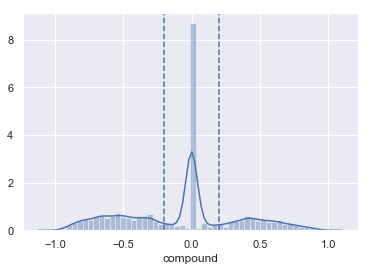

In [22]:
sns.distplot(sentiment['compound'])
plt.axvline(.2, 0, 1,linestyle = '--')
plt.axvline(-.2, 0, 1,linestyle = '--')

In order to further analyze this dataset, we are going to split the tweets into positive or negative, ignoring the neutral tweets for now. We will use +/-0.2 as the cutoff, as seen above.

In [23]:
sentiment['label'] = 0
sentiment.loc[sentiment['compound'] > 0.2, 'label'] = 1
sentiment.loc[sentiment['compound'] < -0.2, 'label'] = -1
sentiment.head()

,compound,neg,neu,pos,tweet,label
0,0.4588,0.193,0.439,0.368,there's no love in town #true #love,1
1,0.0000,0.000,1.000,0.000,#IHaveARightToKnow who Tf texting you at 12 at night,0
2,-0.4199,0.113,0.887,0.000,Little sister: She only got Lion the Witch and the Wardrobe bc she wants to watch the movie! Big sis: *shrugs* #bookseller @eastcitybooks,-1
3,-0.8718,0.473,0.527,0.000,"#joness BREAKING : One Dead, 19 Injured in VA, State of Emergency Declared! https://t.co/bLc9Z5H4dw https://t.co/b5kbvsbhyC",-1
4,-0.2755,0.110,0.890,0.000,It doesn't look like any clock on Antiques Roadshow. The USFA stands for the #Constitution. Enlist at… https://t.co/BTuOk2iazW,-1


In [24]:
pd.set_option('display.max_colwidth', -1)

print("Positive headlines:\n")
print(sentiment.loc[sentiment['label'] == 1].head())

print("Negative headlines:\n")
print(sentiment.loc[sentiment['label'] == -1].head())

# This section needs serious reformatting

Positive headlines:

    compound    neg    neu    pos  \
0   0.4588    0.193  0.439  0.368   
19  0.8579    0.000  0.565  0.435   
32  0.2023    0.000  0.847  0.153   
33  0.2023    0.000  0.878  0.122   
36  0.4019    0.000  0.722  0.278   

                                                                                                                                      tweet  \
0   there's no love in town #true #love                                                                                                       
19  LOL: Sarah Huckabee Just Slapped the BEST ‘Southern Saying’ on Frederica Wilson https://t.co/WQfg7iuXUu                                   
32  handymayhem JackPosobiec YouTube Making some fine points there Uncle Hotep 👍🇺🇸                                                            
33  State Treasury hosts unclaimed property event at Mall of La. https://t.co/9lhGiHdZ9Z \| https://t.co/JGwGUdCT4e https://t.co/cLLoSFAd3L   
36  Altanta welcomes business-to-consumer

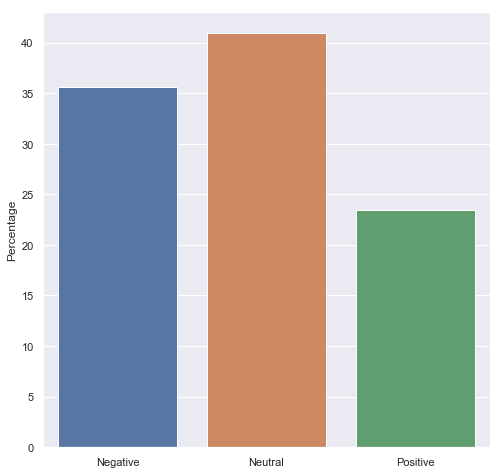

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = sentiment.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

# Things to Investigate / Incorporate

    Strong postive correlation between followers - following.
    
    There is a hashtagger account named "Andy Hashtagger"
    
    "Flatulence and global warming: are we farting ourselves into extinction? #RejectedDebateTopics"
    
    1. Create new features
        a. botometer score of mentioned accts which are still active
        b. sentiment score of tweets
        c. some ratio of followers/following/participation
        d. import news channels and see who mentions which news channels
    2. Use these features to predict updates
    
    What states do these people list in their bio? Does that correlate with anything?
    
    Do positive sentiment tweets containing words relating to psuedoscience count as endorsement?